# Weather Analysis of some Major German Cities

As someone who is constantly cold and just *hates* bad weather, I started looking for climate diagrams that depict exactly that. But it turned out: The kind of data I was interested in was surprisingly hard to come by and usually not up-to-date or configurable. So, I decided to make my only little analysis which, well, is still a work-in-progress. But I hope it will be useful to some of my fellow 'chilly-mortals'. Those of you who always carry a thick sweater or woolen cap, even in summer, know what I mean :)


**Data source**: The data I used is part of the 'opendata' section of the German Metereological Servcie (DWD) and can be found here: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/

I pulled the data on the first of February 2022. 


In the following, I will provide a descriptions of the columns as well:

| Column | Description | Unit |
| ------ | ----------- | ----- |
| STATIONS_ID | station id | |
| MESS_DATUM | begin of interval | yyyymmdd |
| QN_4 | quality level of next columns | coding see paragraph "Quality information" |
|FX| daily maximum of wind gust| m/s|
|FM| daily mean of wind speed| m/s|
|RSK| daily precipitation height| mm|
|RSKF| precipitation form| coding see paragrahp "Precipitation form"|
|SDK |daily sunshine duration| h|
|SHK_TAG| daily snow depth |cm|
|NM| daily mean of cloud cover| 1/8|
|VPM| daily mean of vapor pressure| hPa|
|PM| daily mean of pressure| hPa|
|TMK| daily mean of temperature |°C|
|UPM| daily mean of relative humidity| %|
|TXK| daily maximum of temperature at 2m height|°C|
| ------ | ----------- | ----- |


**Quality Information** 
The quality levels "Qualitätsniveau" (QN) given here apply for the respective following columns. The values
are the minima of the QN of the respective daily values. QN denotes the method of quality control, with which
erroneous values are identified and apply for the whole set of parameters at a certain time. For the individual
parameters there exist quality bytes in the internal DWD data base, which are not published here. Values
identifed as wrong are not published. Various methods of quality control (at different levels) are employed to
decide which value is identified as wrong. In the past, different procedures have been employed. The quality
procedures are coded as following:
quality level (column header: QN_)
1- only formal control during decoding and import
2- controlled with individually defined criteria
3- ROUTINE control with QUALIMET and QCSY
5- historic, subjective procedures
7- ROUTINE control, not yet corrected
8- quality control outside ROUTINE
9- ROUTINE control, not all parameters corrected
10- ROUTINE control finished, respective corrections
finished 

**Precipitation Information**
0- no precipitation (conventional or automatic measurement), relates to WMO code 10
1- only rain (before 1979)
4- unknown form of recorded precipitation
6- only rain; only liquid precipitation at automatic stations, relates to WMO code 11
7- only snow; only solid precipitation at automatic stations, relates to WMO code 12
8- rain and snow (and/or"Schneeregen"); liquid and solid precipitation at automatic stations, relates to WMO code 13
9- error or missing value or no automatic determination of precipitation form, relates to WMO code 15

## Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#load datasets
df_full = pd.read_csv("/datasets/fullclimate/full_climate_daily.txt",header=0,sep=";")
#add names of weather station
dic = {2667: "Köln" , 1078: "Düsseldorf" , 1262: "München" , 1420: "Frankfurt", 2014: "Hannover", 2932: "Leipzig"}
df_full["STATIONS_NAME"] = df_full["STATIONS_ID"].replace(dic)
df_full.replace({-999: 0},inplace=True)

In [ ]:
display(df_full.info())
display(df_full.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138639 entries, 0 to 138638
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   STATIONS_ID    138639 non-null  int64  
 1   MESS_DATUM     138639 non-null  int64  
 2   QN_3           138639 non-null  int64  
 3     FX           138639 non-null  float64
 4     FM           138639 non-null  float64
 5   QN_4           138639 non-null  int64  
 6    RSK           138639 non-null  float64
 7   RSKF           138639 non-null  int64  
 8    SDK           138639 non-null  float64
 9   SHK_TAG        138639 non-null  int64  
 10    NM           138639 non-null  float64
 11   VPM           138639 non-null  float64
 12    PM           138639 non-null  float64
 13   TMK           138639 non-null  float64
 14   UPM           138639 non-null  float64
 15   TXK           138639 non-null  float64
 16   TNK           138639 non-null  float64
 17   TGK           138639 non-nul

None

Index(['STATIONS_ID', 'MESS_DATUM', 'QN_3', '  FX', '  FM', 'QN_4', ' RSK',
       'RSKF', ' SDK', 'SHK_TAG', '  NM', ' VPM', '  PM', ' TMK', ' UPM',
       ' TXK', ' TNK', ' TGK', 'eor', 'STATIONS_NAME'],
      dtype='object')

In [ ]:
#transform columns to datetime

df_full["MESS_DATUM"] = pd.to_datetime(df_full["MESS_DATUM"],format="%Y%m%d")
month_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}
df_full["MONTH"] = df_full["MESS_DATUM"].dt.month
df_full["MONTH"] = df_full["MONTH"].replace(month_dict)
df_full["YEAR"] = df_full["MESS_DATUM"].dt.year


In [ ]:
#am only interested in recent years
df = df_full[df_full["MESS_DATUM"].dt.year >= 2012]

In [ ]:
#add wind-chill factor
df["  FM"] = df["  FM"]*3.6 #transform wind speed to km/h
df["WIND_CHILL"] = 13.12 + 0.6215*df[" TMK"] - 11.37*(df['  FM'])**0.16 + 0.3965*df[" TMK"]*(df['  FM'])**0.16

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#get glimps of data
display(df.head(n=5))

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,...,TMK,UPM,TXK,TNK,TGK,eor,STATIONS_NAME,MONTH,YEAR,WIND_CHILL
7168,1262,2012-01-01,10,11.9,19.08,10,0.0,6,0.9,0,...,8.5,89.0,11.5,3.3,1.6,eor,München,January,2012,5.580361
7169,1262,2012-01-02,10,12.3,12.96,10,0.6,6,0.0,0,...,7.2,82.0,11.9,4.4,1.7,eor,München,January,2012,4.765243
7170,1262,2012-01-03,10,13.3,16.56,10,1.5,6,7.6,0,...,5.0,75.0,8.8,0.9,-1.7,eor,München,January,2012,1.517943
7171,1262,2012-01-04,10,17.3,30.24,10,1.8,6,0.8,0,...,5.3,78.0,9.6,2.1,0.8,eor,München,January,2012,0.421873
7172,1262,2012-01-05,10,27.8,47.52,10,7.4,8,0.0,0,...,4.5,75.0,7.2,1.2,0.6,eor,München,January,2012,-1.863028


In [ ]:
#aggregate values per month and compute mean
cols_avg = ['STATIONS_ID', 'MESS_DATUM', '  FX', '  FM', ' SDK', '  NM', ' VPM', '  PM', ' TMK', ' UPM',
       ' TXK', ' TNK', ' TGK', 'STATIONS_NAME','MONTH', 'WIND_CHILL']
num_years = df["MESS_DATUM"].dt.year.nunique()
df_agg = df.groupby(['STATIONS_NAME', 'MONTH'], observed=True)[cols_avg].mean()
df_agg[" RSK"] = df.groupby(["STATIONS_NAME","MONTH"])[" RSK"].sum()/num_years
df_agg["SHK_TAG"] = df.groupby(["STATIONS_NAME","MONTH"])["SHK_TAG"].sum()/num_years
display(df_agg)

STATIONS_ID         FX         FM       SDK  \
STATIONS_NAME MONTH                                                    
Düsseldorf    April             1078  10.637778  13.212000  5.844378   
              August            1078  10.539427  12.641290  6.733444   
              December          1078  11.875986  17.850323  1.437695   
              February          1078  11.846275  17.443765  3.022667   
              January           1078  11.693548  17.116129  1.581835   
...                              ...        ...        ...       ...   
München       March             1262  10.728674  13.122581  5.067681   
              May               1262   9.782437  10.335484  6.621799   
              November          1262   8.684815  10.648000  2.223963   
              October           1262   8.321864   9.140645  3.693595   
              September         1262   8.228519   8.521333  5.680922   

                               NM        VPM           PM        TMK  \
STATIONS_NAME MONTH                                                    
Düsseldorf    April      4.867407   8.480741  1010.228667  10.635556   
              August     4.701075  15.133692  1011.149892  19.468100   
              December   6.263441   7.962366  1012.000358   5.705735   
              February   5.409412   6.496471  1011.516588   3.991373   
              January    6.141219   6.989247  1010.991971   3.970609   
...                           ...        ...          ...        ...   
München       March      5.306093   6.522222   963.353047   5.027599   
              May        5.532616  11.059857   963.187563  13.137993   
              November   6.537037   7.694815   963.816926   4.698148   
              October    5.855556  10.230466   965.448602   9.463082   
              September  5.032593  12.859630   966.127852  13.932963   

                               UPM        TXK        TNK        TGK  \
STATIONS_NAME MONTH                                                   
Düsseldorf    April      66.945185  15.914444   4.586667   1.567407   
              August     68.862473  24.952688  13.735125  11.435125   
              December   85.035018   8.055197   2.967025   1.212186   
              February   77.373451   7.401569   0.441961  -1.871373   
              January    83.397706   6.501792   1.015771  -0.874910   
...                            ...        ...        ...        ...   
München       March      74.983405  10.401434  -0.770968  -3.012903   
              May        74.164409  18.656272   6.866308   4.931900   
              November   88.488074   8.260370   0.781111  -0.721852   
              October    85.937097  14.426523   4.238710   2.526523   
              September  81.248630  19.798889   7.774444   6.163704   

                         WIND_CHILL        RSK    SHK_TAG  
STATIONS_NAME MONTH                                        
Düsseldorf    April        9.027556  34.555556   0.000000  
              August      19.813999  65.222222   0.000000  
              December     2.443990  72.288889   3.333333  
              February     0.423264  55.366667   3.888889  
              January      0.475374  62.033333  15.222222  
...                             ...        ...        ...  
München       March        2.424062  32.644444   8.555556  
              May         12.488213  94.400000   0.000000  
              November     2.469841  43.244444   0.777778  
              October      8.402871  57.200000   0.666667  
              September   13.661463  58.188889   0.000000  

[72 rows x 15 columns]

In [ ]:
df_rsk = df.groupby(["STATIONS_NAME","MONTH","RSKF"])[" RSK"].sum()/num_years

In [ ]:
#reindex df to avoid lexicographical sorting of months
df_agg = df_agg.reindex(["January","February","March","April","May","June","July","August","September","October","November","December"], level=1)
df_rsk = df_rsk.reindex(["January","February","March","April","May","June","July","August","September","October","November","December"], level=1)

In [ ]:
df_agg.head(n=20)

STATIONS_ID         FX         FM       SDK  \
STATIONS_NAME MONTH                                                    
Düsseldorf    January           1078  11.693548  17.116129  1.581835   
              February          1078  11.846275  17.443765  3.022667   
              March             1078  11.415771  15.521290  4.360025   
              April             1078  10.637778  13.212000  5.844378   
              May               1078  10.335125  12.456774  6.769412   
              June              1078  10.477778  12.738667  6.533400   
              July              1078  10.423656  12.179355  7.053086   
              August            1078  10.539427  12.641290  6.733444   
              September         1078   9.508519  12.201333  5.295915   
              October           1078  10.542294  14.830968  3.206190   
              November          1078  10.800000  15.560000  2.212081   
              December          1078  11.875986  17.850323  1.437695   
Frankfurt     January           1420  11.000717  13.525161  1.527652   
              February          1420  11.278431  13.636235  2.935553   
              March             1420  11.438351  13.308387  4.825756   
              April             1420  11.247778  12.200000  6.737156   
              May               1420  11.184946  11.781935  7.181065   
              June              1420  11.370370  11.656000  7.648770   
              July              1420  11.540502  11.678710  8.097724   
              August            1420  10.755197  10.588387  7.365538   

                               NM        VPM           PM        TMK  \
STATIONS_NAME MONTH                                                    
Düsseldorf    January    6.141219   6.989247  1010.991971   3.970609   
              February   5.409412   6.496471  1011.516588   3.991373   
              March      5.219355   7.200358  1011.045591   6.939427   
              April      4.867407   8.480741  1010.228667  10.635556   
              May        4.958065  10.892473  1011.035448  14.222939   
              June       5.047037  13.634444  1011.169556  17.809630   
              July       4.706810  15.070609  1011.221219  19.805735   
              August     4.701075  15.133692  1011.149892  19.468100   
              September  4.762963  13.000741  1012.584074  15.454074   
              October    5.595341  11.376703  1011.118208  11.912545   
              November   5.852222   8.875926  1009.650630   7.464074   
              December   6.263441   7.962366  1012.000358   5.705735   
Frankfurt     January    6.294982   6.541577  1004.512222   3.092832   
              February   5.616863   6.080784  1004.667333   3.250588   
              March      5.086380   6.905735  1003.544588   6.987455   
              April      4.798148   8.171111  1002.312963  11.377778   
              May        5.039427  10.984229  1002.964480  14.949462   
              June       4.813333  13.855556  1003.313926  18.952593   
              July       4.613620  14.700717  1003.404480  21.264516   
              August     4.637276  15.103584  1003.834301  20.435842   

                               UPM        TXK        TNK        TGK  \
STATIONS_NAME MONTH                                                   
Düsseldorf    January    83.397706   6.501792   1.015771  -0.874910   
              February   77.373451   7.401569   0.441961  -1.871373   
              March      72.021147  11.397133   2.167025  -0.620430   
              April      66.945185  15.914444   4.586667   1.567407   
              May        68.090179  19.577419   8.169534   5.490681   
              June       68.230704  22.987778  12.093333   9.670741   
              July       67.276738  25.258423  13.881720  11.645878   
              August     68.862473  24.952688  13.735125  11.435125   
              September  75.002481  20.686296  10.261852   7.635185   
              October    80.928566  15.699283   8.069892   5.913262   
   

In [ ]:
display(df_rsk.head(n=10))
display(df_rsk.loc[:,:,8])


STATIONS_NAME  MONTH     RSKF
Düsseldorf     January   0        0.000000
                         6       46.133333
                         7        1.977778
                         8       13.922222
               February  0        0.000000
                         6       37.855556
                         7        0.322222
                         8       17.188889
               March     0        0.000000
                         6       34.622222
Name:  RSK, dtype: float64

STATIONS_NAME  MONTH   
Düsseldorf     January     13.922222
               February    17.188889
               March       10.722222
               April        6.166667
               May          7.266667
                             ...    
München        July         8.288889
               August       3.488889
               October      1.244444
               November     7.722222
               December     8.622222
Name:  RSK, Length: 61, dtype: float64

<AxesSubplot:xlabel='MONTH'>

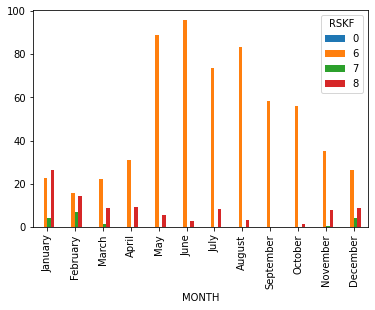

In [ ]:
df_rsk.loc["München"].unstack().plot(kind='bar', stacked=False)


## Statistical Overview

In [ ]:
for cities in df["STATIONS_NAME"].unique():
    display(cities)
    display(df[df["STATIONS_NAME"] == cities].describe())
    print("\n")

'München'

,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,YEAR,WIND_CHILL
count,3288.0,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000
mean,1262.0,9.870134,9.595925,10.672007,7.081204,1.978224,3.943735,5.197175,0.409672,5.550912,9.961648,964.579297,9.585554,79.126986,14.623418,4.032056,2.240298,2016.000000,8.220037
std,0.0,0.944706,4.400739,6.351818,3.451931,4.594482,3.126508,4.686181,1.952834,2.130593,4.215144,7.573657,7.554313,11.064054,9.028060,6.666510,6.985794,2.583088,9.075894
min,1262.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,927.200000,-15.900000,35.000000,-9.900000,-23.100000,-26.900000,2012.000000,-18.500994
25%,1262.0,10.000000,6.500000,6.480000,3.000000,0.000000,0.000000,0.500000,0.000000,4.200000,6.400000,960.375000,3.600000,71.000000,7.400000,-0.800000,-2.400000,2014.000000,0.928439
50%,1262.0,10.000000,8.700000,9.000000,10.000000,0.000000,6.000000,4.200000,0.000000,6.100000,9.200000,964.995000,9.600000,79.980000,14.900000,4.000000,2.100000,2016.000000,8.197382
75%,1262.0,10.000000,11.800000,12.960000,10.000000,1.700000,6.000000,9.233000,0.000000,7.300000,13.200000,969.400000,15.700000,88.000000,21.700000,9.400000,7.700000,2018.000000,15.590736
max,1262.0,10.000000,33.100000,53.640000,10.000000,58.000000,8.000000,15.467000,20.000000,8.000000,21.700000,989.480000,26.200000,100.000000,35.300000,19.000000,17.500000,2020.000000,28.046417


'Köln'

,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,YEAR,WIND_CHILL
count,3288.0,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.00000,3288.000000,3288.000000,3288.00000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000
mean,2667.0,9.870134,9.788382,11.561715,7.081204,2.048814,4.020985,4.38615,0.078771,5.447901,10.42649,1004.329072,11.242974,75.516727,15.963869,6.247597,4.592974,2016.000000,9.960387
std,0.0,0.944706,3.672027,4.446042,3.451931,4.231596,2.994750,4.31864,0.754380,2.006376,3.96595,8.873712,6.721035,12.021317,8.100530,5.945494,6.294108,2.583088,8.153240
min,2667.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.50000,965.400000,-10.200000,28.920000,-4.300000,-17.600000,-20.300000,2012.000000,-15.127294
25%,2667.0,10.000000,7.200000,8.280000,3.000000,0.000000,0.000000,0.40000,0.000000,4.300000,7.30000,999.215000,6.000000,68.000000,9.600000,1.900000,0.200000,2014.000000,3.595585
50%,2667.0,10.000000,9.300000,10.800000,10.000000,0.100000,6.000000,3.10000,0.000000,5.900000,9.80000,1004.640000,11.100000,77.000000,15.800000,6.300000,4.800000,2016.000000,9.812860
75%,2667.0,10.000000,11.800000,14.040000,10.000000,2.300000,6.000000,7.50000,0.000000,7.000000,13.20000,1010.100000,16.400000,84.842500,22.200000,10.800000,9.300000,2018.000000,16.168075
max,2667.0,10.000000,31.900000,36.000000,10.000000,48.700000,8.000000,15.40000,14.000000,8.000000,23.10000,1034.650000,31.000000,100.000000,40.300000,21.900000,20.400000,2020.000000,33.712434


'Düsseldorf'

,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,YEAR,WIND_CHILL
count,3288.0,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.00000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000
mean,1078.0,9.870134,10.839325,14.469197,7.081204,1.847019,4.049878,4.509875,0.066302,5.294617,10.448571,1011.142521,11.48750,74.766150,15.784641,6.831113,4.487470,2016.000000,9.915440
std,0.0,0.944706,3.939292,6.371196,3.451931,3.799147,2.975093,4.301170,0.677678,1.988546,3.821505,9.139202,6.67163,12.014657,7.880181,5.978122,6.301533,2.583088,8.245292
min,1078.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,971.900000,-9.10000,0.000000,-5.400000,-13.800000,-17.300000,2012.000000,-15.591358
25%,1078.0,10.000000,8.200000,9.360000,3.000000,0.000000,0.000000,0.500000,0.000000,4.100000,7.400000,1005.997500,6.40000,67.000000,9.500000,2.300000,0.000000,2014.000000,3.371305
50%,1078.0,10.000000,10.300000,13.320000,10.000000,0.100000,6.000000,3.325000,0.000000,5.800000,9.900000,1011.500000,11.30000,76.040000,15.500000,7.000000,4.600000,2016.000000,9.642016
75%,1078.0,10.000000,12.900000,18.360000,10.000000,2.000000,6.000000,7.641500,0.000000,6.800000,13.100000,1017.200000,16.60000,84.000000,21.825000,11.425000,9.225000,2018.000000,16.311912
max,1078.0,10.000000,39.500000,42.120000,10.000000,56.300000,8.000000,15.483000,13.000000,8.000000,22.400000,1042.060000,31.20000,100.000000,40.700000,23.300000,22.600000,2020.000000,33.942168


'Frankfurt'

,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,YEAR,WIND_CHILL
count,3288.0,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000
mean,1420.0,9.870134,10.802798,11.944161,7.081204,1.583546,3.897202,4.863556,0.080292,5.347354,10.194891,1003.993604,11.579197,72.789249,16.150091,6.903832,5.119799,2016.000000,10.392924
std,0.0,0.944706,3.759634,5.613125,3.451931,3.729489,3.047802,4.534742,0.727320,1.993810,3.969099,8.487034,7.378044,14.069655,8.801268,6.498783,6.638450,2.583088,8.882599
min,1420.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.600000,965.400000,-10.900000,27.420000,-7.500000,-16.000000,-20.100000,2012.000000,-18.242384
25%,1420.0,10.000000,8.200000,7.920000,3.000000,0.000000,0.000000,0.467000,0.000000,4.175000,7.000000,999.007500,5.675000,62.000000,8.900000,1.900000,0.100000,2014.000000,3.155381
50%,1420.0,10.000000,10.400000,10.440000,10.000000,0.000000,6.000000,3.800000,0.000000,5.800000,9.600000,1004.200000,11.300000,74.000000,16.000000,6.800000,4.900000,2016.000000,10.096245
75%,1420.0,10.000000,12.900000,15.120000,10.000000,1.225000,6.000000,8.500000,0.000000,6.900000,13.000000,1009.400000,17.400000,84.000000,23.000000,12.000000,10.200000,2018.000000,17.375766
max,1420.0,10.000000,35.000000,38.880000,10.000000,50.200000,8.000000,15.667000,18.000000,8.000000,21.900000,1033.160000,32.000000,100.000000,40.100000,25.700000,23.500000,2020.000000,34.869048


'Hannover'

,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,YEAR,WIND_CHILL
count,3288.0,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000
mean,2014.0,9.870134,10.741727,13.760693,7.081204,1.630322,4.226277,4.447367,0.096715,5.482451,10.285219,1008.487540,10.589446,77.364462,14.793218,6.197141,3.738321,2016.000000,8.900049
std,0.0,0.944706,3.953026,5.740142,3.451931,3.781613,2.913605,4.302997,0.742726,1.886051,3.915107,9.098937,6.899902,11.668853,8.199580,6.089752,6.118471,2.583088,8.550537
min,2014.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.700000,967.200000,-13.000000,39.000000,-8.500000,-18.200000,-20.300000,2012.000000,-19.267801
25%,2014.0,10.000000,7.900000,9.360000,3.000000,0.000000,0.000000,0.345750,0.000000,4.400000,7.200000,1003.200000,5.500000,69.710000,8.400000,2.000000,-0.500000,2014.000000,2.322863
50%,2014.0,10.000000,10.300000,12.960000,10.000000,0.000000,6.000000,3.208500,0.000000,5.900000,9.700000,1008.825000,10.400000,79.000000,14.450000,6.200000,3.700000,2016.000000,8.597164
75%,2014.0,10.000000,12.900000,16.920000,10.000000,1.500000,6.000000,7.583000,0.000000,7.000000,13.000000,1014.400000,16.000000,86.000000,21.100000,10.900000,8.300000,2018.000000,15.634702
max,2014.0,10.000000,31.600000,40.680000,10.000000,46.900000,8.000000,15.417000,12.000000,8.000000,22.300000,1038.470000,29.200000,100.000000,37.900000,21.200000,20.100000,2020.000000,31.578035


'Leipzig'

,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,YEAR,WIND_CHILL
count,3288.0,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000
mean,2932.0,9.870134,10.577828,14.686861,7.081204,1.291363,3.870438,4.968577,0.249088,5.435736,9.942792,999.904595,10.604319,74.952445,15.038443,6.171746,3.872415,2016.000000,8.775760
std,0.0,0.944706,4.119601,6.620510,3.451931,3.454853,3.075305,4.539501,1.341005,1.965016,3.935898,8.472782,7.632554,13.004143,8.963354,6.724030,6.765085,2.583088,9.491154
min,2932.0,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,958.600000,-17.300000,33.380000,-13.600000,-21.500000,-26.500000,2012.000000,-22.214423
25%,2932.0,10.000000,7.600000,9.720000,3.000000,0.000000,0.000000,0.400000,0.000000,4.300000,6.800000,994.900000,4.800000,65.000000,8.075000,1.100000,-0.800000,2014.000000,1.257167
50%,2932.0,10.000000,9.800000,13.320000,10.000000,0.000000,6.000000,4.100000,0.000000,5.900000,9.400000,1000.100000,10.300000,76.420000,14.900000,6.200000,4.050000,2016.000000,8.394410
75%,2932.0,10.000000,12.825000,18.000000,10.000000,1.000000,6.000000,8.500000,0.000000,7.000000,12.700000,1005.335000,16.600000,85.000000,22.100000,11.500000,8.900000,2018.000000,16.309239
max,2932.0,10.000000,35.700000,48.600000,10.000000,58.900000,8.000000,15.767000,14.000000,8.000000,25.700000,1029.040000,30.200000,100.000000,38.300000,22.600000,20.300000,2020.000000,32.768818


## Visualisation of some Averages
The following plots show the average of some characteristics from 2012 to 2020.

In [ ]:
import plotly.express as px 
import plotly.graph_objects as go

In [ ]:
#average precipitation height in mm

cities = df["STATIONS_NAME"].unique()
fig = go.Figure()

for city in cities:
    fig.add_trace(go.Scatter(x=df_agg.loc[city].index.get_level_values(0), y=df_agg.loc[city][" RSK"],
                    mode='lines',
                    name=city))

fig.update_layout(
    title="Average Precipitation height",
    xaxis_title="Month",
    yaxis_title="Precipitation height in mm",
    legend_title="City",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
#average temperature
fig = go.Figure()

for city in cities:
    fig.add_trace(go.Scatter(x=df_agg.loc[city].index.get_level_values(0), y=df_agg.loc[city][" TMK"],
                    mode='lines',
                    name=city))

fig.update_layout(
    title="Average Temperature",
    xaxis_title="Month",
    yaxis_title="Temperature in °C",
    legend_title="City",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
#plot average wind speed
fig = go.Figure()

for city in cities:
    fig.add_trace(go.Scatter(x=df_agg.loc[city].index.get_level_values(0), y=df_agg.loc[city]["  FM"],
                    mode='lines',
                    name=city))

fig.update_layout(
    title="Average Wind Speed",
    xaxis_title="Month",
    yaxis_title="Wind speed in km/h",
    legend_title="City",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
#plot average duration of sun shine
fig = go.Figure()

for city in cities:
    fig.add_trace(go.Scatter(x=df_agg.loc[city].index.get_level_values(0), y=df_agg.loc[city][" SDK"],
                    mode='lines',
                    name=city))

fig.update_layout(
    title="Average Hours of Sunshine",
    xaxis_title="Month",
    yaxis_title="Sunshine in h",
    legend_title="City",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
#average relative humidity
fig = go.Figure()

for city in cities:
    fig.add_trace(go.Scatter(x=df_agg.loc[city].index.get_level_values(0), y=df_agg.loc[city][" UPM"],
                    mode='lines',
                    name=city))

fig.update_layout(
    title="Average Relative Humidity",
    xaxis_title="Month",
    yaxis_title="Relative humidity",
    legend_title="City",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
#average wind chill
fig = go.Figure()

for city in cities:
    fig.add_trace(go.Scatter(x=df_agg.loc[city].index.get_level_values(0), y=df_agg.loc[city]["WIND_CHILL"],
                    mode='lines',
                    name=city))

fig.update_layout(
    title="Average Wind-Chill",
    xaxis_title="Month",
    yaxis_title="Wind-Chill in °C",
    legend_title="City",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
df

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,...,TMK,UPM,TXK,TNK,TGK,eor,STATIONS_NAME,MONTH,YEAR,WIND_CHILL
7168,1262,2012-01-01,10,11.9,19.08,10,0.0,6,0.900,0,...,8.5,89.00,11.5,3.3,1.6,eor,München,January,2012,5.580361
7169,1262,2012-01-02,10,12.3,12.96,10,0.6,6,0.000,0,...,7.2,82.00,11.9,4.4,1.7,eor,München,January,2012,4.765243
7170,1262,2012-01-03,10,13.3,16.56,10,1.5,6,7.600,0,...,5.0,75.00,8.8,0.9,-1.7,eor,München,January,2012,1.517943
7171,1262,2012-01-04,10,17.3,30.24,10,1.8,6,0.800,0,...,5.3,78.00,9.6,2.1,0.8,eor,München,January,2012,0.421873
7172,1262,2012-01-05,10,27.8,47.52,10,7.4,8,0.000,0,...,4.5,75.00,7.2,1.2,0.6,eor,München,January,2012,-1.863028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138634,2932,2020-12-27,3,19.7,30.96,3,0.0,6,0.233,0,...,1.3,63.21,3.1,-0.2,-0.9,eor,Leipzig,December,2020,-4.871276
138635,2932,2020-12-28,3,9.9,15.48,3,0.0,8,1.900,0,...,2.2,76.88,5.2,0.2,-1.1,eor,Leipzig,December,2020,-1.785321
138636,2932,2020-12-29,3,13.4,19.44,3,0.0,6,0.233,0,...,2.1,85.42,4.8,-0.4,-2.3,eor,Leipzig,December,2020,-2.515217
138637,2932,2020-12-30,3,9.4,16.20,3,0.2,6,3.283,0,...,2.8,82.79,5.4,0.6,-1.0,eor,Leipzig,December,2020,-1.159755


In [ ]:
#average snowfall
fig = go.Figure()

months = ["October","November","December","January","February","March"]
for city in cities:
    fig.add_trace(go.Scatter(x=months, y=df_agg.loc[city,months,:]["SHK_TAG"],
                    mode='lines',
                    name=city))

fig.update_layout(
    title="Average Amount of Snowfall",
    xaxis_title="Month",
    yaxis_title="Snowfall in cm",
    legend_title="City",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
#average wind chill
from plotly.subplots import make_subplots 
import plotly
fig = make_subplots(rows=2,cols=1,shared_xaxes=True)

cols = plotly.colors.DEFAULT_PLOTLY_COLORS

i=0
for city in cities:
    fig.append_trace(go.Scatter(x=df_agg.loc[city].index.get_level_values(0), 
    y=df_agg.loc[city]["WIND_CHILL"]/df_agg.loc[city][" UPM"],
                    mode='lines',
                    name=city,
                    line=dict(width=2, color=cols[i]),
                    ), row = 1, col=1)
    fig.append_trace(go.Scatter(x=df_agg.loc[city].index.get_level_values(0), y=df_agg.loc[city]["WIND_CHILL"],
                    mode='lines',name=city,showlegend=False,
                    line=dict(width=2, color=cols[i])
                    ), row=2,col=1)
    i+=1
fig.update_layout(
    title="Comparison of Wind-Chill to Extended Wind-Chill",
    xaxis_title="Month",
    legend_title="City",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ),
    height = 700
)
fig.update_yaxes(title_text=" Extended Wind-Chill", row=1, col=1)
fig.update_yaxes(title_text=" Wind-Chill", row=2, col=1)


fig.show()

## Towards an Apparent Temperature
An interesting extension would be to design a heuristic which ranked the cities according to the overall 'chilly-mortal friendliness'. But this seems to involve an actual study conducted among people and would probably also need more data, especially labelled data. And also: Every individuial has different preferences and needs, hence the heuristic would definitely look different from one person to another.
To keep things simple, I decided to extend the notion of wind-chill by factoring in the relative humiditiy. As you can see the overall difference in city ranking is not very different to the one resulting from wind-chill.

## Time Series Analysis 
Most will know the myth that there once was a time when it snowed way more than today. So I got curious: Does that assumption actually hold for the last 30 years? I looked at the amount of snowfall for Leipzig and Munich of the last 30 years. And as it turns out, the trend has been steadily low in the last 8 years, meaning less snow for us :( 

In [ ]:
plt.style.use('fivethirtyeight')

In [ ]:
leipzig = df_full[df_full["STATIONS_NAME"]=="Leipzig"].groupby("MESS_DATUM")["SHK_TAG"].sum().reset_index()
leipzig = leipzig.set_index("MESS_DATUM")
y = leipzig.loc["1975":]["SHK_TAG"].resample("MS").mean()

munx = df_full[df_full["STATIONS_NAME"]=="München"].groupby("MESS_DATUM")["SHK_TAG"].sum().reset_index()
munx = munx.set_index("MESS_DATUM")
x = munx.loc["1975":]["SHK_TAG"].resample("MS").mean()

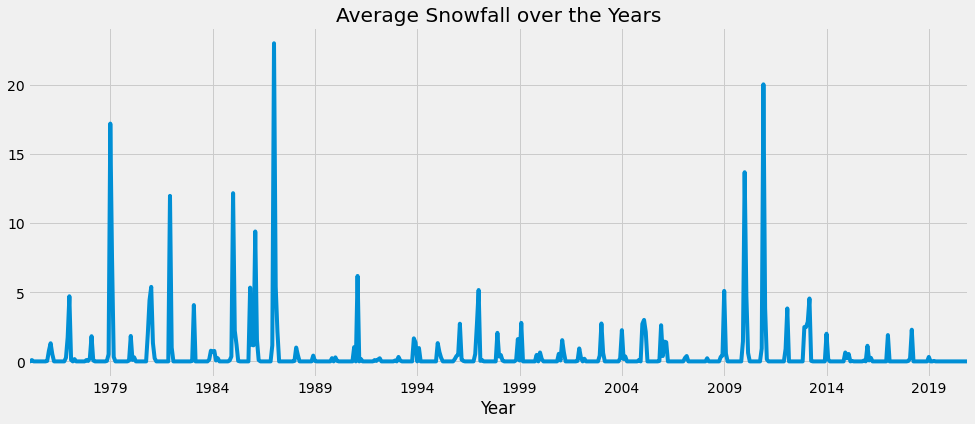

In [ ]:
fig, axes = plt.subplots(1,1)
y.plot(figsize=(15,6),ax=axes)
axes.set_xlabel("Year")
axes.set_title("Average Snowfall over the Years")
plt.show()

In [ ]:
import statsmodels.api as sm

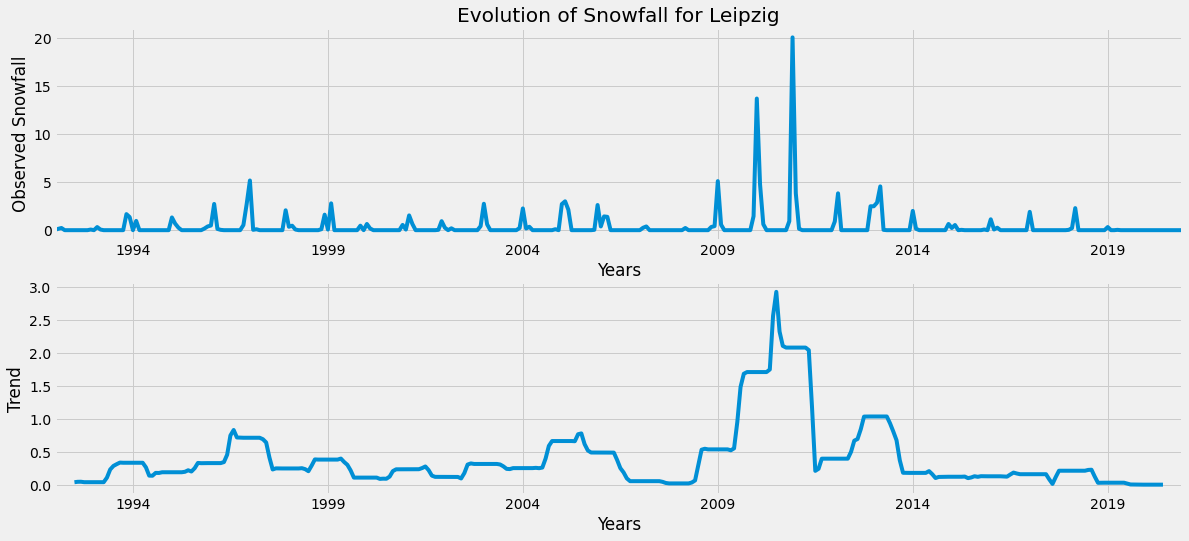

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
y = y["1992":]
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig, ax = plt.subplots(2,1)
decomposition.observed.plot(ax=ax[0],legend=False)
ax[0].set_title("Evolution of Snowfall for Leipzig")
ax[0].set_ylabel("Observed Snowfall")
ax[0].set_xlabel("Years")
decomposition.trend.plot(ax=ax[1],legend=False)
ax[1].set_ylabel("Trend")
ax[1].set_xlabel("Years")
plt.show()


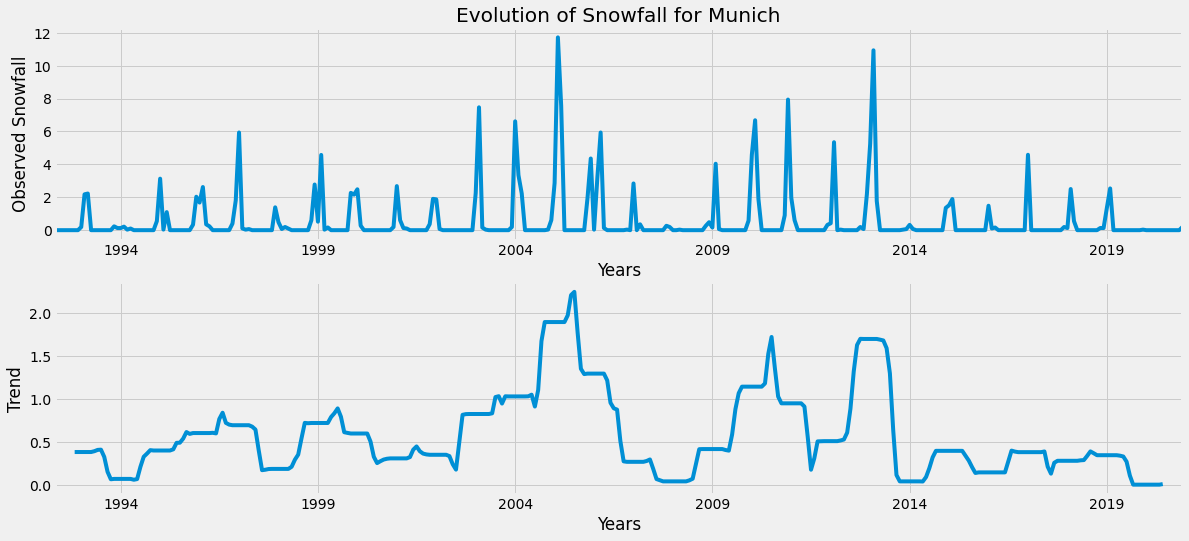

In [ ]:
decomposition = sm.tsa.seasonal_decompose(x, model='additive')
fig, ax = plt.subplots(2,1)
decomposition.observed.plot(ax=ax[0],legend=False)
ax[0].set_title("Evolution of Snowfall for Munich")
ax[0].set_ylabel("Observed Snowfall")
ax[0].set_xlabel("Years")
decomposition.trend.plot(ax=ax[1],legend=False)
ax[1].set_ylabel("Trend")
ax[1].set_xlabel("Years")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f92120ac-322a-482c-b7bc-b6682c50d559' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>